In [5]:
from pathlib import Path
import xarray as xr

In [6]:

BASE = Path("../../../New_Analysis/updated_files/yearly/CFS/")

def open_clim(fname, scale=1.0):
    """Open your comp_clim outputs and apply scaling (e.g., albedo /100)."""
    return xr.open_dataset(BASE / fname) * scale

def pick_mean_std_nobs(ds: xr.Dataset, prefix: str):
    """
    prefix example: 'albedo', 'srads', 'trads', 'ahfs', ...
    Returns a dict with keys: mean, std, nobs, period (if present).
    """
    out = {}
    for key, suffix in [("mean", "mean"), ("std", "std"), ("nobs", "nobs")]:
        vname = f"{prefix}_{suffix}"
        if vname not in ds:
            raise KeyError(f"Missing {vname}. Found: {list(ds.data_vars)}")
        out[key] = ds[vname]

    # keep period if it exists (some files store it as a data_var or coord)
    if "period" in ds:
        out["period"] = ds["period"]
    elif "period" in ds.coords:
        out["period"] = ds.coords["period"]
    else:
        out["period"] = None

    return out

# ----------------------------
# Define ONLY ZERO + MOD, and surface + TOA variables
# Fill in your prefixes correctly (the prefix must match your variable naming before _mean/_std/_nobs)
# ----------------------------
MODEL = "CFS"  # or "SINTEX"

FILES = {
    "CFS": {
        "surface": {
            "albedo": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_albedo_interpECHAM.nc", 1/100, "albedo"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_albedo_interpECHAM.nc", 1/100, "albedo"),
            },
            "shortwave": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_srads_interpECHAM.nc", 1.0, "srads"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_srads_interpECHAM.nc", 1.0, "srads"),
            },
            "longwave": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_trads_interpECHAM.nc", 1.0, "trads"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_trads_interpECHAM.nc", 1.0, "trads"),
            },
            "sensible": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_ahfs_interpECHAM.nc", 1.0, "ahfs"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_ahfs_interpECHAM.nc", 1.0, "ahfs"),
            },
        },
        "toa": {
            "albedo": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_albedo0_interpECHAM.nc", 1.0, "albedo0"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_albedo0_interpECHAM.nc", 1, "albedo0"),
            },
            "shortwave": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_srad0_interpECHAM.nc", 1.0, "srad0"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_srad0_interpECHAM.nc", 1.0, "srad0"),
            },
            "longwave": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_olr_interpECHAM.nc", 1.0, "olr"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_olr_interpECHAM.nc", 1.0, "olr"),
            },
            "net_heat_flux": {
                "ZERO": ("clim_CFS2ALB0_1y_2014_2044_rad0_interpECHAM.nc", 1.0, "rad0"),
                "MOD":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_rad0_interpECHAM.nc", 1.0, "rad0"),
            },
        },
    }
}

def load_bundle(model="CFS"):
    cfg = FILES[model.upper()]
    out = {"surface": {}, "toa": {}}

    for domain in ["surface", "toa"]:
        for var in cfg[domain]:
            out[domain][var] = {}
            for exp in ["ZERO", "MOD"]:
                fname, scale, prefix = cfg[domain][var][exp]
                ds = open_clim(fname, scale)
                out[domain][var][exp] = pick_mean_std_nobs(ds, prefix)

    return out

bundle = load_bundle(MODEL)

In [7]:

def annualize_mean_std(mean_da, std_da, time_dim="time", std_method="rms_std"):
    """
    Convert 12-step climatology along `time` to a single (lat,lon) field.
    std_method:
      - "mean_std": std = mean(std over time)  (simple)
      - "rms_std" : std = sqrt(mean(std^2 over time)) (usually better)
    """
    if time_dim in mean_da.dims:
        mean_out = mean_da.mean(time_dim, skipna=True)
    else:
        mean_out = mean_da

    if time_dim in std_da.dims:
        if std_method == "mean_std":
            std_out = std_da.mean(time_dim, skipna=True)
        elif std_method == "rms_std":
            std_out = np.sqrt((std_da**2).mean(time_dim, skipna=True))
        else:
            raise ValueError("std_method must be 'mean_std' or 'rms_std'")
    else:
        std_out = std_da

    return mean_out, std_out

def make_var_dict_old_annual(bundle, domain, varnames, time_dim="time", std_method="rms_std"):
    out = {}
    for var in varnames:
        z = bundle[domain][var]["ZERO"]
        m = bundle[domain][var]["MOD"]

        m0, s0 = annualize_mean_std(z["mean"], z["std"], time_dim=time_dim, std_method=std_method)
        m1, s1 = annualize_mean_std(m["mean"], m["std"], time_dim=time_dim, std_method=std_method)

        out[var] = (m0, s0, m1, s1)  # (ZERO mean/std, MOD mean/std) -> ZERO - MOD in your test
    return out



In [8]:
import numpy as np
import xarray as xr
from scipy.stats import t
def check_same_shape(name, m1, s1, m2, s2):
    shapes = [m1.shape, s1.shape, m2.shape, s2.shape]
    dims   = [m1.dims,  s1.dims,  m2.dims,  s2.dims]
    ok = (shapes[0]==shapes[1]==shapes[2]==shapes[3]) and (dims[0]==dims[1]==dims[2]==dims[3])
    if not ok:
        print(f"[SHAPE MISMATCH] {name}:")
        print(f"  mean_ctrl: {m1.shape} {m1.dims}")
        print(f"  std_ctrl : {s1.shape} {s1.dims}")
        print(f"  mean_sens: {m2.shape} {m2.dims}")
        print(f"  std_sens : {s2.shape} {s2.dims}")
    return ok

def welch_ttest_numpy_wrap(name, mean_ctrl, std_ctrl, mean_sens, std_sens, n_ctrl, n_sens):
    """
    Strict: no coord renaming/aligning. Requires identical dims/shape across inputs.
    Uses NumPy on .values to avoid xarray auto-alignment; wraps result on mean_ctrl coords.
    """
    if not check_same_shape(name, mean_ctrl, std_ctrl, mean_sens, std_sens):
        raise ValueError(f"{name}: inputs are not on the exact same grid/dims.")
    # compute with numpy
    mc = mean_ctrl.values
    sc = std_ctrl.values
    ms = mean_sens.values
    ss = std_sens.values

    se = np.sqrt((sc**2)/n_ctrl + (ss**2)/n_sens)
    # avoid divide-by-zero warnings
    with np.errstate(divide='ignore', invalid='ignore'):
        t_stat = (mc - ms) / se
        df_num = (sc**2/n_ctrl + ss**2/n_sens)**2
        df_den = ((sc**2/n_ctrl)**2)/(n_ctrl - 1) + ((ss**2/n_sens)**2)/(n_sens - 1)
        df = df_num / df_den
        p_val = 2 * (1 - t.cdf(np.abs(t_stat), df))

    t_da = xr.DataArray(t_stat, coords=mean_ctrl.coords, dims=mean_ctrl.dims, name=f"t_{name}")
    p_da = xr.DataArray(p_val, coords=mean_ctrl.coords, dims=mean_ctrl.dims, name=f"p_{name}")
    return t_da, p_da

def run_all_tests_strict(var_dict, n_ctrl, n_sens, alpha=0.05):
    tstats, pvals, sig = {}, {}, {}
    for name, (m1,s1,m2,s2) in var_dict.items():
        t_da, p_da = welch_ttest_numpy_wrap(name, m1, s1, m2, s2, n_ctrl, n_sens)
        tstats[name] = t_da
        pvals[name]  = p_da
        sig[name]    = (p_da < alpha).rename(f"sig_{name}")
    return tstats, pvals, sig

def make_var_dict_old(bundle, domain, varnames=None):
    """
    domain: 'surface' or 'toa'
    Returns old workflow dict:
      var_dict[var] = (mean_ZERO, std_ZERO, mean_MOD, std_MOD)
    """
    out = {}
    keys = varnames if varnames is not None else list(bundle[domain].keys())

    for var in keys:
        z = bundle[domain][var]["ZERO"]
        m = bundle[domain][var]["MOD"]
        out[var] = (z["mean"], z["std"], m["mean"], m["std"])  # ZERO then MOD
    return out



In [9]:
N_CTRL, N_SENS = 100, 50
# Surface
surf_vars = make_var_dict_old_annual(
    bundle, "surface",
    ["albedo", "shortwave", "longwave", "sensible"],
    time_dim="time",
    std_method="rms_std"   # or "mean_std" if you want the simplest
)
t_surf, p_surf, sig_surf = run_all_tests_strict(surf_vars, N_CTRL, N_SENS, alpha=0.1)

# TOA (use the exact key you have in bundle["toa"])
toa_key_flux = "net_heat_flux"   # change to "rad0" if that’s your key
toa_vars = make_var_dict_old_annual(
    bundle, "toa",
    ["albedo", "shortwave", "longwave", toa_key_flux],
    time_dim="time",
    std_method="rms_std"
)
t_toa, p_toa, sig_toa = run_all_tests_strict(toa_vars, N_CTRL, N_SENS, alpha=0.1)


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import string
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr

proj = ccrs.Robinson(central_longitude=210)
pc = ccrs.PlateCarree()

def latlon_names(da):
    if 'lat' in da.coords and 'lon' in da.coords:
        return 'lat', 'lon'
    if 'latitude' in da.coords and 'longitude' in da.coords:
        return 'latitude', 'longitude'
    raise ValueError("Couldn't find lat/lon coordinate names in DataArray.")

def nonsig_mask_for(da, sig_mask):
    """Return int mask (0/1) with dims matching da for contourf; 1 where NOT significant."""
    lat_name, lon_name = latlon_names(da)

    if isinstance(sig_mask, xr.DataArray):
        sig_mask = sig_mask.reindex_like(da, method=None)

    # ensure same dim order for broadcasting / contourf
    if sig_mask.dims != da.dims:
        sig_mask = sig_mask.transpose(*da.dims)

    return (~sig_mask).astype(int)

from matplotlib.colors import TwoSlopeNorm
import numpy as np

def zero_center_norm(da, pct=98):
    """
    Create a TwoSlopeNorm centered at zero using symmetric limits
    based on a percentile of absolute values.
    """
    vmax = np.nanpercentile(np.abs(da.values), pct)
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    return TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)


def plot_surface_vs_toa_differences(
    bundle,
    sig_surf,
    sig_toa,
    exp_label="ZERO − MOD",
    savepath=None,
    cmap="RdBu_r",
    levels_map=None,   # optional dict: var -> levels array
    label_map=None     # optional dict: var -> colorbar label
):
    """
    4x2 plot, differences only, hatch non-significant.
    Left column: Surface (albedo, shortwave, longwave, sensible)
    Right column: TOA (albedo, shortwave, longwave, net_heat_flux)
    """

    # Row definitions: (display name, surface_key, toa_key)
    rows = [
        ("Albedo",      "albedo",      "albedo"),
        ("Shortwave",   "shortwave",   "shortwave"),
        ("Longwave",    "longwave",    "longwave"),
        ("Flux",        "sensible",    "net_heat_flux"),  # TOA net heat flux (rad0)
    ]

    fig, axes = plt.subplots(
        4, 2, figsize=(12, 14),
        subplot_kw={'projection': proj},
        constrained_layout=True
    )

    labels = list(string.ascii_lowercase)
    label_idx = 0

    for row, (row_name, surf_key, toa_key) in enumerate(rows):
        for col in range(2):
            ax = axes[row, col]

            if col == 0:
                # Surface difference: ZERO - MOD
                # Surface difference: ZERO - MOD
                da = (
                    bundle["surface"][surf_key]["ZERO"]["mean"]
                    - bundle["surface"][surf_key]["MOD"]["mean"]
                )
                
                # Reverse sign ONLY for surface sensible heat flux
                if surf_key == "sensible":
                    da = -da
                
                sig_mask = sig_surf.get(surf_key, None)
                col_title = "Surface"
                var_for_levels = surf_key

                sig_mask = sig_surf.get(surf_key, None)
                col_title = "Surface"
                var_for_levels = surf_key
            else:
                # TOA difference: ZERO - MOD
                da = (
                    bundle["toa"][toa_key]["ZERO"]["mean"]
                    - bundle["toa"][toa_key]["MOD"]["mean"]
                )
                
                # Reverse sign ONLY for TOA longwave radiation (OLR)
                if toa_key == "longwave":
                    da = -da
                
                sig_mask = sig_toa.get(toa_key, None)
                col_title = "TOA"
                var_for_levels = toa_key


            lat_name, lon_name = latlon_names(da)

            # Levels/labels (optional)
            UNIT_LABELS = {
                    "albedo": "",                  # fraction → no unit
                    "shortwave": "W m$^{-2}$",
                    "longwave": "W m$^{-2}$",
                    "sensible": "W m$^{-2}$",
                    "net_heat_flux": "W m$^{-2}$",  # or "rad0"
                    "rad0": "W m$^{-2}$",
                }


            norm = zero_center_norm(da)
            unit = UNIT_LABELS.get(var_for_levels, "")
            
            da.plot.pcolormesh(
                ax=ax,
                transform=pc,
                cmap=cmap,
                norm=norm,
                cbar_kwargs={
                    "orientation": "horizontal",
                    "label": unit,
                    "shrink": 0.7,
                    "pad": 0.05
                },
                add_colorbar=True
            )



            # Hatch NON-significant (skip for panel a)
            if sig_mask is not None and not (row == 0 and col == 0):
                nonsig = nonsig_mask_for(da, sig_mask)
                Z = nonsig.transpose(lat_name, lon_name).values
                ax.contourf(
                    da[lon_name].values, da[lat_name].values, Z,
                    levels=[0.5, 1.5],
                    colors='none', hatches=['...'],
                    transform=pc
                )


            # Coastlines & land
            ax.coastlines(linewidth=0.6)
            ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)

            # Gridlines (same pattern)
            gl = ax.gridlines(crs=pc, draw_labels=False, linewidth=0.3,
                              color='gray', alpha=0.5, linestyle='--')
            gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
            gl.ylocator = mticker.FixedLocator(np.arange(-60,  61, 30))

            # Left column: y labels
            if col == 0:
                gll = ax.gridlines(crs=pc, draw_labels=True, linewidth=0)
                gll.ylocator = mticker.FixedLocator(np.arange(-60,  61, 30))
                gll.top_labels = False
                gll.bottom_labels = False
                gll.right_labels = False
                gll.ylabel_style = {'size': 8}

            # Bottom row: x labels
            if row == 3:
                glb = ax.gridlines(crs=pc, draw_labels=True, linewidth=0)
                glb.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
                glb.top_labels = False
                glb.left_labels = False
                glb.right_labels = False
                glb.xlabel_style = {'size': 8}

            # Title (panel label + row name + column + exp label) — no model name
            if row_name.startswith("Flux"):
                title_var = "Sensible heat flux" if col == 0 else "Net radiation"
            else:
                title_var = row_name
            
            ax.set_title(
                f"({labels[label_idx]}) {title_var} — {col_title}",
                fontsize=11
            )


            label_idx += 1

    if savepath is None:
        savepath = f"Figure_Surface_TOA_{exp_label.replace(' ', '_')}.pdf"
    plt.savefig(savepath, dpi=600, bbox_inches='tight')
    plt.show()


In [11]:
diff_surf = {k: surf_vars[k][0] - surf_vars[k][2] for k in surf_vars}
diff_toa  = {k: toa_vars[k][0]  - toa_vars[k][2]  for k in toa_vars}


In [12]:
def make_bundle_annual_from_vars(surf_vars, toa_vars):
    # surf_vars[var] = (m0,s0,m1,s1) where 0=ZERO, 1=MOD
    # toa_vars[var]  = (m0,s0,m1,s1)
    out = {"surface": {}, "toa": {}}

    for var, (m0,s0,m1,s1) in surf_vars.items():
        out["surface"][var] = {
            "ZERO": {"mean": m0, "std": s0},
            "MOD":  {"mean": m1, "std": s1},
        }

    for var, (m0,s0,m1,s1) in toa_vars.items():
        out["toa"][var] = {
            "ZERO": {"mean": m0, "std": s0},
            "MOD":  {"mean": m1, "std": s1},
        }

    return out

bundle_annual = make_bundle_annual_from_vars(surf_vars, toa_vars)


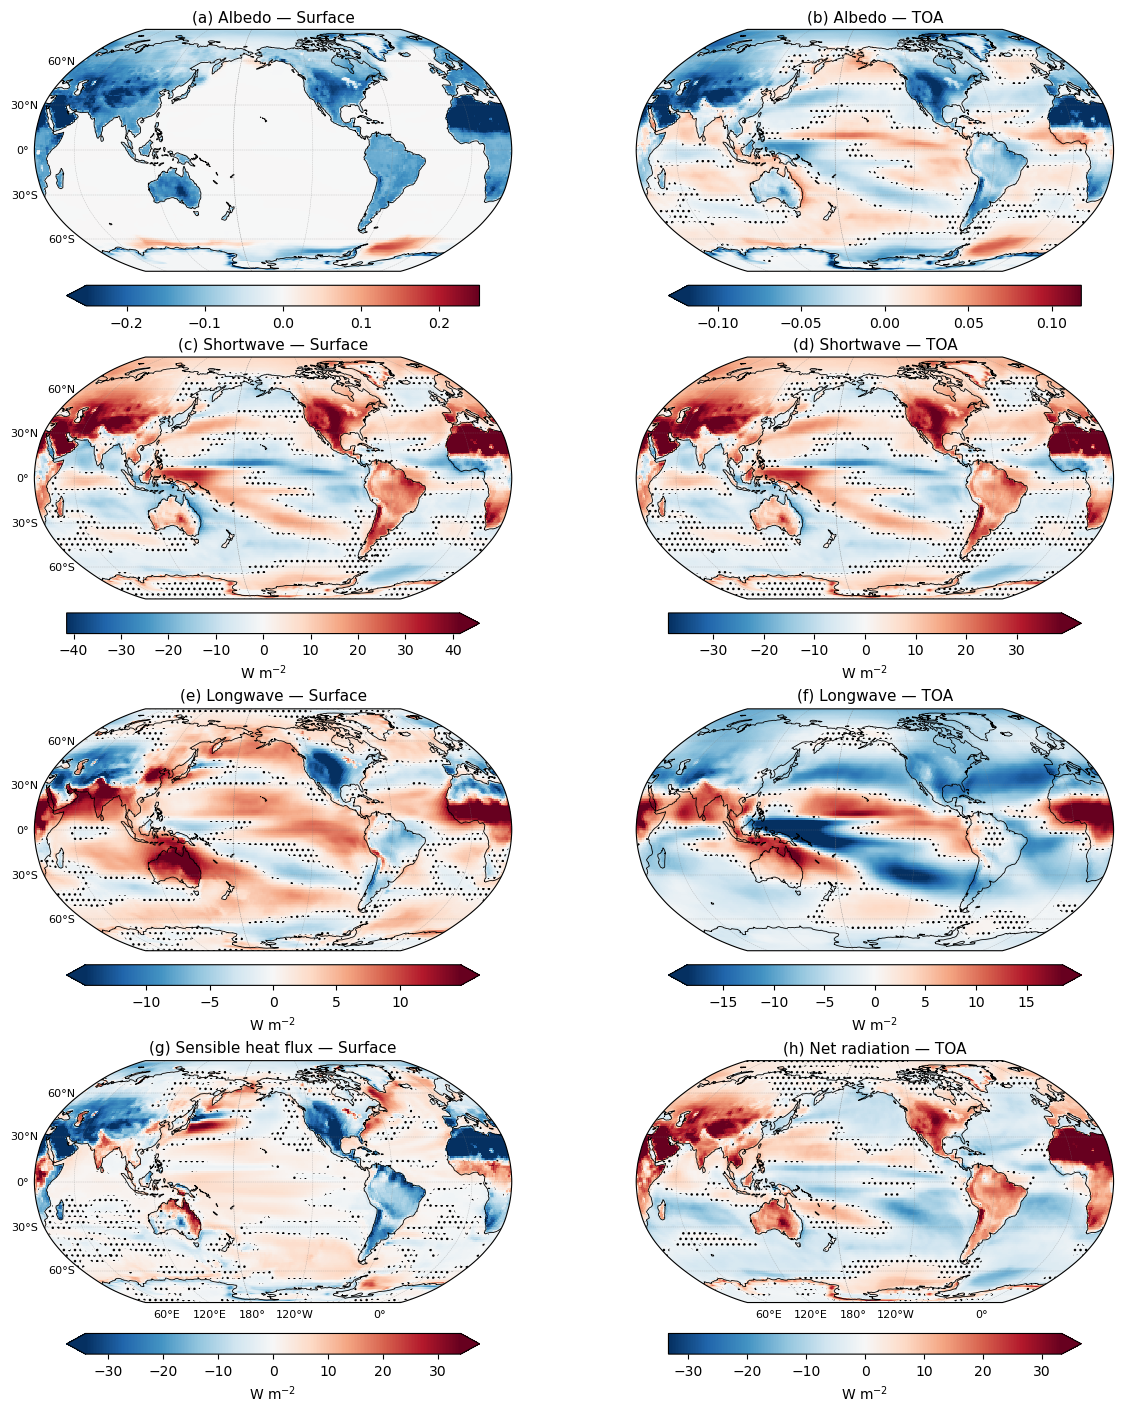

In [13]:
plot_surface_vs_toa_differences(
    bundle=bundle_annual,
    sig_surf=sig_surf,
    sig_toa=sig_toa,
    exp_label="",
    savepath="Figure_Surface_TOA_ZERO_minus_MOD_CFS.pdf"
)


In [7]:
BASE = Path("../../../New_Analysis/updated_files/yearly/SINTEX/")

MODEL = "SINTEX"  # or "SINTEX"

FILES = {
    "SINTEX": {
        "surface": {
            "albedo": {
                "ZERO": ("clim_zero_1y_190001_195912_albedo.nc", 1, "albedo"),
                "MOD":  ("clim_ALB_1y_000101_011012_albedo.nc", 1, "albedo"),
            },
            "shortwave": {
                "ZERO": ("clim_zero_1y_190001_195912_srads.nc", 1.0, "srads"),
                "MOD":  ("clim_ALB_1y_000101_011012_srads.nc", 1.0, "srads"),
            },
            "longwave": {
                "ZERO": ("clim_zero_1y_190001_195912_trads.nc", 1.0, "trads"),
                "MOD":  ("clim_ALB_1y_000101_011012_trads.nc", 1.0, "trads"),
            },
            "sensible": {
                "ZERO": ("clim_zero_1y_190001_195912_ahfs.nc", 1.0, "ahfs"),
                "MOD":  ("clim_ALB_1y_000101_011012_ahfs.nc", 1.0, "ahfs"),
            },
        },
        "toa": {
            "albedo": {
                "ZERO": ("clim_zero_1y_190001_195912_albedo0.nc", 1.0, "albedo0"),
                "MOD":  ("clim_ALB_1y_000101_011012_albedo0.nc", 1, "albedo0"),
            },
            "shortwave": {
                "ZERO": ("clim_zero_1y_190001_195912_srad0.nc", 1.0, "srad0"),
                "MOD":  ("clim_ALB_1y_000101_011012_srad0.nc", 1.0, "srad0"),
            },
            "longwave": {
                "ZERO": ("clim_zero_1y_190001_195912_trad0.nc", 1.0, "trad0"),
                "MOD":  ("clim_ALB_1y_000101_011012_trad0.nc", 1.0, "trad0"),
            },
            "net_heat_flux": {
                "ZERO": ("clim_zero_1y_190001_195912_rad0.nc", 1.0, "rad0"),
                "MOD":  ("clim_ALB_1y_000101_011012_rad0.nc", 1.0, "rad0"),
            },
        },
    }
}

In [8]:
bundle = load_bundle(MODEL)

C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\xarray\coding\times.py:170: SerializationWarning: Ambiguous reference date string: 1-01-31 23:54:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-31 23:54:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\xarray\coding\times.py:995: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime o

In [9]:
N_CTRL, N_SENS = 75, 25
# Surface
surf_vars = make_var_dict_old_annual(
    bundle, "surface",
    ["albedo", "shortwave", "longwave", "sensible"],
    time_dim="time",
    std_method="rms_std"   # or "mean_std" if you want the simplest
)
t_surf, p_surf, sig_surf = run_all_tests_strict(surf_vars, N_CTRL, N_SENS, alpha=0.1)

# TOA (use the exact key you have in bundle["toa"])
toa_key_flux = "net_heat_flux"   # change to "rad0" if that’s your key
toa_vars = make_var_dict_old_annual(
    bundle, "toa",
    ["albedo", "shortwave", "longwave", toa_key_flux],
    time_dim="time",
    std_method="rms_std"
)
t_toa, p_toa, sig_toa = run_all_tests_strict(toa_vars, N_CTRL, N_SENS, alpha=0.1)


In [10]:
diff_surf = {k: surf_vars[k][0] - surf_vars[k][2] for k in surf_vars}
diff_toa  = {k: toa_vars[k][0]  - toa_vars[k][2]  for k in toa_vars}


In [11]:
bundle_annual = make_bundle_annual_from_vars(surf_vars, toa_vars)


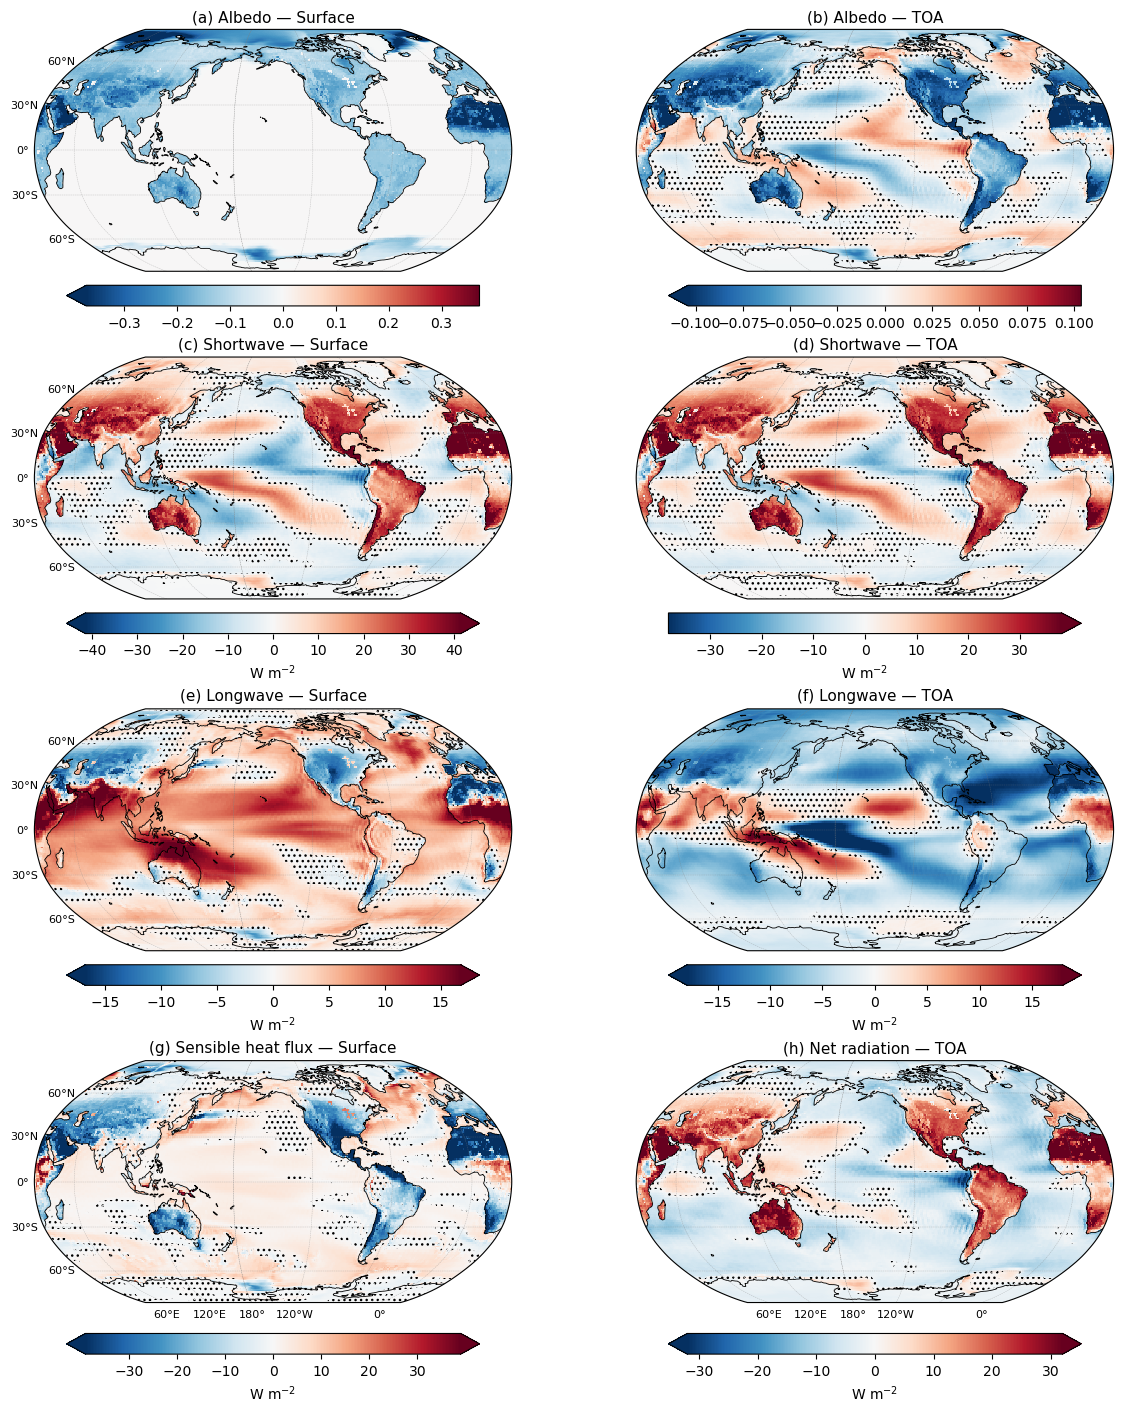

In [12]:
plot_surface_vs_toa_differences(
    bundle=bundle_annual,
    sig_surf=sig_surf,
    sig_toa=sig_toa,
    exp_label="",
    savepath="Figure_Surface_TOA_ZERO_minus_MOD_SINTEX.pdf"
)


In [ ]:
data_dict_zm = {
    "Surface Albedo (CTRL)": {
        "CFS":    (cfs_t_mean, 'turbo', np.linspace(0, 0.5, 21), ''),
        "SINTEX": (sin_t_mean, 'turbo', np.linspace(0,  0.5,  21), '')
    },
    "Surface Albedo (MODIS-CTRL)": {
        "CFS":    ((cfs_t_mean_mod-cfs_t_mean), 'RdBu_r', np.linspace(-0.2, 0.2, 21), ''),
        "SINTEX": ((sin_t_mean_mod-sin_t_mean), 'RdBu_r', np.linspace(-0.2, 0.2, 21), '')
    },
    "Surface Albedo (ZERO)": {
        "CFS":    (cfs_zero_t_mean, 'turbo', np.linspace(0, 0.5, 21), ''),
        "SINTEX": (sin_zero_t_mean, 'turbo', np.linspace(0, 0.5, 21), '')
    }
}